## 📙 Import libraries and modules

In [1]:
# Importing essential libraries
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()

46

## ⚙️ Configuration

In [2]:
# Configuration class containing hyperparameters and settings
class Config:
    seed = 42 
    image_transform = transforms.Resize((512,512))  
    batch_size = 16
    num_epochs = 9
    num_folds = 5

# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

# Define the 'Kullback Leibler Divergence' loss function
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

# Reclaim memory no longer in use.
gc.collect()

0

In [3]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')


Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.
There are 20183 unique eeg_id + votes in the training data.


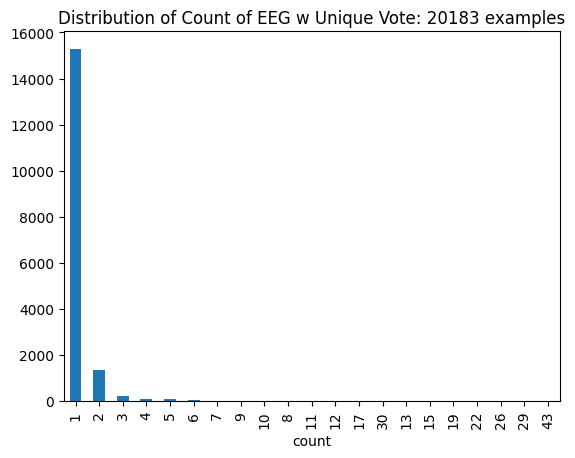

In [4]:
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

df['total_evaluators'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

df_uniq = df.drop_duplicates(subset=['eeg_id'] + list(TARGETS))
# df_uniq = df_uniq.sort_values('eeg_id', ascending=True)
print(f'There are {df.patient_id.nunique()} patients in the training data.')
print(f'There are {df.eeg_id.nunique()} EEG IDs in the training data.')
print(f'There are {df_uniq.shape[0]} unique eeg_id + votes in the training data.')

df_uniq.eeg_id.value_counts().value_counts().plot(kind='bar', title=f'Distribution of Count of EEG w Unique Vote: '
                                                                    f'{df_uniq.shape[0]} examples');

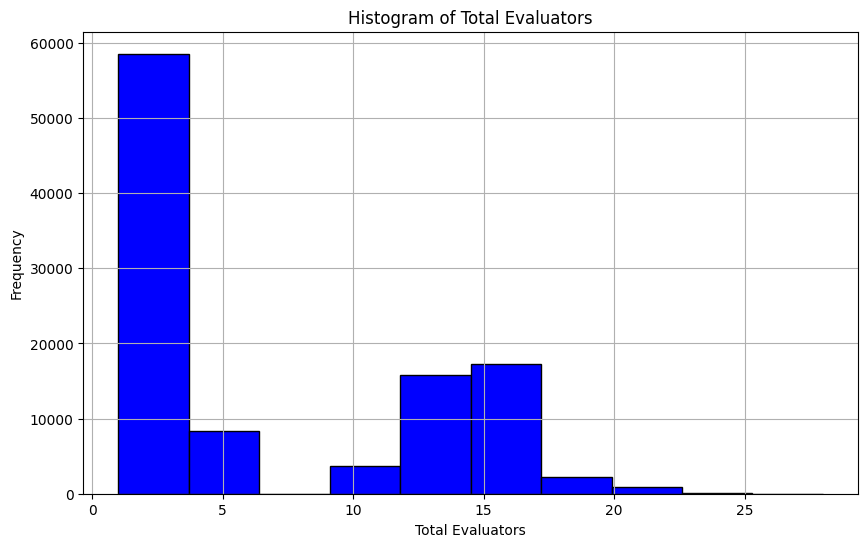

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
EVAL_ONLY = False
# if not EVAL_ONLY:
#     spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

In [7]:
if not EVAL_ONLY:
    all_eegs = np.load('/kaggle/input/eeg-spectrogram-by-label-id-unique/eeg_specs.npy',allow_pickle=True).item()

Pop 1: train unique eeg_id + votes shape: (13833, 18)


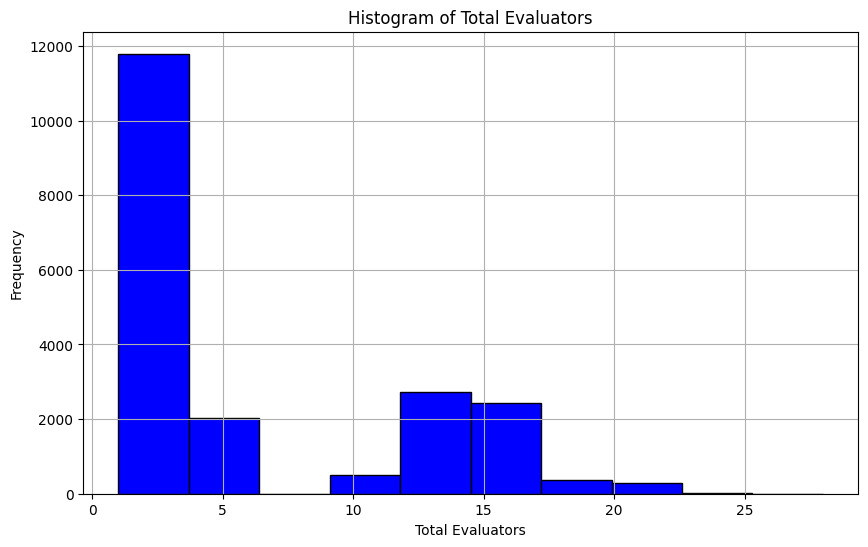

In [8]:
train = df[df['label_id'].isin(all_eegs.keys())].copy()
    
pop_1_idx = train['total_evaluators'] < 10

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

train_pop_1 = train[pop_1_idx].copy().reset_index()
train_pop_2 = train[~pop_1_idx].copy().reset_index()
# train = train.reset_index()
print('Pop 1: train unique eeg_id + votes shape:', train_pop_1.shape )
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
# should container spectrogram ID and then do the split and train first on one and then on second

In [10]:
train_pop_1.head()

,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_evaluators,target
0,0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,Seizure
1,22,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3,LRDA
2,28,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,Seizure
3,30,1626798710,0,0.0,1219001,2,74.0,3631726128,23435,Seizure,0.6,0.0,0.4,0.0,0.0,0.0,5,Seizure
4,32,2529955608,0,0.0,1219001,4,190.0,4265493714,23435,Seizure,0.6,0.0,0.4,0.0,0.0,0.0,5,Seizure


## 📂 Data Loading

In [11]:
# Load training data
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

# Define labels for classification
labels = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

# Initialize an empty DataFrame for storing features
train_feats = pd.DataFrame()

# Aggregate votes for each label and merge into train_feats DataFrame
for label in labels:
    # Group by 'spectrogram_id' and sum the votes for the current label
    group = train_df[f'{label}_vote'].groupby(train_df['spectrogram_id']).sum()

    # Create a DataFrame from the grouped data
    label_vote_sum = pd.DataFrame({'spectrogram_id': group.index, f'{label}_vote_sum': group.values})

    # Initialize train_feats with the first label or merge subsequent labels
    if label == 'seizure':
        train_feats = label_vote_sum
    else:
        train_feats = train_feats.merge(label_vote_sum, on='spectrogram_id', how='left')

# Add a column to sum all votes
train_feats['total_vote'] = 0
for label in labels:
    train_feats['total_vote'] += train_feats[f'{label}_vote_sum']

# Calculate and store the normalized vote for each label
for label in labels:
    train_feats[f'{label}_vote'] = train_feats[f'{label}_vote_sum'] / train_feats['total_vote']

# Select relevant columns for the training features
choose_cols = ['spectrogram_id']
for label in labels:
    choose_cols += [f'{label}_vote']
train_feats = train_feats[choose_cols]

# Add a column with the path to the spectrogram files
train_feats['path'] = train_feats['spectrogram_id'].apply(lambda x: "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/" + str(x) + ".parquet")

# Reclaim memory no longer in use.
gc.collect()

9879

In [12]:
train_feats

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
1,924234,0.000000,0.0000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...
2,999431,0.000000,0.0625,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...
3,1084844,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
4,1219001,0.677419,0.0000,0.322581,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
11133,2146188334,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...
11134,2146414988,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
11135,2146798838,0.000000,0.5000,0.000000,0.111111,0.000000,0.388889,/kaggle/input/hms-harmful-brain-activity-class...
11136,2147312808,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...


In [13]:
train_feats_pop_1 = train_feats[train_feats['spectrogram_id'].isin(train_pop_1['spectrogram_id'])].copy().reset_index(drop=True)
train_feats_pop_2 = train_feats[train_feats['spectrogram_id'].isin(train_pop_2['spectrogram_id'])].copy().reset_index(drop=True)

In [14]:
train_feats_pop_1

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.00,0.000000,0.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
1,1084844,0.000000,0.00,0.000000,1.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
2,1219001,0.677419,0.00,0.322581,0.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
3,1730458,0.000000,0.00,0.133333,0.0,0.0,0.866667,/kaggle/input/hms-harmful-brain-activity-class...
4,1872874,0.250000,0.25,0.000000,0.5,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
7609,2146166212,0.000000,0.00,0.000000,0.5,0.0,0.500000,/kaggle/input/hms-harmful-brain-activity-class...
7610,2146170054,0.906977,0.00,0.093023,0.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
7611,2146414988,0.000000,1.00,0.000000,0.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
7612,2147312808,0.000000,1.00,0.000000,0.0,0.0,0.000000,/kaggle/input/hms-harmful-brain-activity-class...


In [15]:
train_feats_pop_2

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,924234,0.0,0.000000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...
1,999431,0.0,0.062500,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...
2,1353070,0.0,0.000000,0.357143,0.000000,0.000000,0.642857,/kaggle/input/hms-harmful-brain-activity-class...
3,2207717,0.0,0.000000,0.150000,0.000000,0.675000,0.175000,/kaggle/input/hms-harmful-brain-activity-class...
4,3452193,0.0,0.000000,0.166667,0.000000,0.666667,0.166667,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
4697,2145400096,0.0,0.071429,0.000000,0.357143,0.000000,0.571429,/kaggle/input/hms-harmful-brain-activity-class...
4698,2145546675,0.0,0.636364,0.090909,0.000000,0.000000,0.272727,/kaggle/input/hms-harmful-brain-activity-class...
4699,2145983945,0.0,0.066667,0.000000,0.666667,0.000000,0.266667,/kaggle/input/hms-harmful-brain-activity-class...
4700,2146188334,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...


## 🎰 Data Preprocessing

In [16]:
def get_batch(paths, batch_size=Config.batch_size):
    # Set a small epsilon to avoid division by zero
    eps = 1e-6

    # Initialize a list to store batch data
    batch_data = []

    # Iterate over each path in the provided paths
    for path in paths:
        # Read data from parquet file
        data = pd.read_parquet(path[0])

        # Fill missing values, remove time column, and transpose
        data = data.fillna(-1).values[:, 1:].T

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data_mean = data.mean(axis=(0, 1))
        data_std = data.std(axis=(0, 1))
        data = (data - data_mean) / (data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = Config.image_transform(data_tensor)

        # Append the processed data to the batch_data list
        batch_data.append(data)

    # Stack all the batch data into a single tensor
    batch_data = torch.stack(batch_data)

    # Return the batch data
    return batch_data

## 🤖 Model Training

In [17]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm
import numpy as np
import gc


# Determine device availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming train_feats_pop_1 and train_feats_pop_2 are defined
populations = [train_feats_pop_1, train_feats_pop_2]

# Initialize ResNet34d model with pretrained weights
model = timm.create_model('resnet34d', pretrained=True, num_classes=6, in_chans=1)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=Config.num_epochs)



for population_idx, train_feats_pop in enumerate(populations):
    # Assuming train_feats_pop is defined and contains the training features and labels
    
    total_idx = np.arange(len(train_feats_pop))
    np.random.shuffle(total_idx)

    gc.collect()

    # Cross-validation loop
    for fold in range(Config.num_folds):
        best_test_loss = float('inf')
        train_losses = []
        test_losses = []
        # Split data into train and test sets for this fold
        test_idx = total_idx[fold * len(total_idx) // Config.num_folds:(fold + 1) * len(total_idx) // Config.num_folds]
        train_idx = np.array([idx for idx in total_idx if idx not in test_idx])

        print(f"Starting training for fold {fold + 1} in population {population_idx+1}")

           # Training loop
        for epoch in range(Config.num_epochs):
            model.train()
            train_loss = []
            random_num = np.arange(len(train_idx))
            np.random.shuffle(random_num)
            train_idx = train_idx[random_num]

            # Iterate over batches in the training set
            for idx in range(0, len(train_idx), Config.batch_size):
                optimizer.zero_grad()
                train_idx1 = train_idx[idx:idx + Config.batch_size]
                train_X1_path = train_feats_pop[['path']].iloc[train_idx1].values
                train_X1 = get_batch(train_X1_path, batch_size=Config.batch_size).to(device)
                train_y1 = train_feats_pop[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[train_idx1].values
                train_y1 = torch.Tensor(train_y1).to(device)

                train_pred = model(train_X1)
                loss = KL_loss(train_y1, train_pred)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())

            epoch_train_loss = np.mean(train_loss)
            train_losses.append(epoch_train_loss)
            print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

            scheduler.step()

            # Evaluation loop
            model.eval()
            test_loss = []
            with torch.no_grad():
                for idx in range(0, len(test_idx), Config.batch_size):
                    test_idx1 = test_idx[idx:idx + Config.batch_size]
                    test_X1_path = train_feats_pop[['path']].iloc[test_idx1].values
                    test_X1 = get_batch(test_X1_path, batch_size=Config.batch_size).to(device)
                    test_y1 = train_feats_pop[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].iloc[test_idx1].values
                    test_y1 = torch.Tensor(test_y1).to(device)

                    test_pred = model(test_X1)
                    loss = KL_loss(test_y1, test_pred)
                    test_loss.append(loss.item())

            epoch_test_loss = np.mean(test_loss)
            test_losses.append(epoch_test_loss)
            print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

            # Save the model if it has the best test loss so far
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                model_path = os.path.join('/kaggle/working', f"resnet34d_fold{fold}_pop{population_idx + 1}.pth")
                torch.save(model.state_dict(), model_path)
                print(f"Model saved for epoch {epoch + 1}, fold {fold}_pop{population_idx + 1}: Test Loss = {epoch_test_loss:.2f}")

            gc.collect()
            torch.cuda.empty_cache()

        print(f"Fold {fold + 1} Populations {population_idx+1} Best Test Loss: {best_test_loss:.2f}")

Using device: cuda


model.safetensors:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

Starting training for fold 1 in population 1
Epoch 1: Train Loss = 1.05
Epoch 1: Test Loss = 0.93
Model saved for epoch 1, fold 0_pop1: Test Loss = 0.93
Epoch 2: Train Loss = 0.83
Epoch 2: Test Loss = 0.97
Epoch 3: Train Loss = 0.72
Epoch 3: Test Loss = 0.77
Model saved for epoch 3, fold 0_pop1: Test Loss = 0.77
Epoch 4: Train Loss = 0.63
Epoch 4: Test Loss = 0.66
Model saved for epoch 4, fold 0_pop1: Test Loss = 0.66
Epoch 5: Train Loss = 0.55
Epoch 5: Test Loss = 0.76
Epoch 6: Train Loss = 0.45
Epoch 6: Test Loss = 0.69
Epoch 7: Train Loss = 0.35
Epoch 7: Test Loss = 0.63
Model saved for epoch 7, fold 0_pop1: Test Loss = 0.63
Epoch 8: Train Loss = 0.24
Epoch 8: Test Loss = 0.63
Epoch 9: Train Loss = 0.18
Epoch 9: Test Loss = 0.65
Fold 1 Populations 1 Best Test Loss: 0.63
Starting training for fold 2 in population 1
Epoch 1: Train Loss = 0.29
Epoch 1: Test Loss = 0.13
Model saved for epoch 1, fold 1_pop1: Test Loss = 0.13
Epoch 2: Train Loss = 0.29
Epoch 2: Test Loss = 0.15
Epoch 3: T